In [1]:
import numpy as np
import ase
import scipy.linalg

In [2]:
hexaset=[]
hexamin_loc=[]
the_vectors=np.array([[-1,0,0],[1,0,0],[0,-1,0],[0,1,0],[0,0,-1],[0,0,1]])
for k in range(806,16182,5):
    hexamin_array=[]
    start=np.loadtxt("dipoles/Sys"+str(k)+"/dipoles.out")[54:108,:]
    for k in range(np.shape(start)[0]):
        angle_set=np.arccos(np.dot(start[k,:],np.transpose(the_vectors)/scipy.linalg.norm(start[k,:])))/np.pi*180
        hexaset.append(np.min(angle_set))
        hexamin_array.append(np.where(np.min(angle_set)==angle_set)[0][0])
    hexamin_loc.append(hexamin_array)

In [3]:
np.savetxt('hexamin_loc',hexamin_loc)

In [4]:
files=[]
for counter in range (1,55):
    files.append('../sites/trajectories/r'+str(counter)+'/XDATCAR')

In [5]:
from pymatgen.io.vasp.outputs import Xdatcar

In [6]:
trajectory_list = (Xdatcar(f) for f in files)
structures = ([x.structures for x in trajectory_list])

In [7]:
flat_list = []
for sublist in structures:
    for item in sublist:
        flat_list.append(item)

In [8]:
sss=flat_list[0]
box_x=sss.lattice.a
box_y=sss.lattice.b
box_z=sss.lattice.c

In [9]:
from tqdm import tqdm

In [10]:
angular_store=[]
radial_store=[]
for k in tqdm(range(806,16182,5)):
    Sn=np.array(flat_list[k].cart_coords[54:108,:])
    F=np.array(flat_list[k].cart_coords[108:,:])
    rx=np.zeros((216,54))
    ry=np.zeros((216,54))
    rz=np.zeros((216,54))
    for x in range(216):
        ry[x,:]=(Sn[:,1]-F[x,1]) 
        rx[x,:]=(Sn[:,0]-F[x,0]) 
        rz[x,:]=(Sn[:,2]-F[x,2])
    rx-= (np.ceil((np.abs(rx)-box_x/2)/box_x))*((box_x))*np.sign(rx)
    ry-= (np.ceil((np.abs(ry)-box_y/2)/box_y))*((box_y))*np.sign(ry)
    rz-= (np.ceil((np.abs(rz)-box_z/2)/box_z))*((box_z))*np.sign(rz)
    r=np.sqrt(rx**2+ry**2+rz**2)
    start=np.loadtxt("/Users/swc57/qpdf/quickPDF/for_wann_BaNew/Sys"+str(k)+"/dipoles.out")[54:108,:]
    dx=start[:,0]
    dy=start[:,1]
    dz=start[:,2]
    dip=np.sqrt(dx**2+dy**2+dz**2)
    for l in range (54):
        cosstuff=np.arccos(((rx[:,l]*dx[l])+(ry[:,l]*dy[l])+(rz[:,l]*dz[l]))/dip[l]/r[:,l])
        angular_store.append(cosstuff)
        radial_store.append(r[:,l])

100%|███████████████████████████████████████| 3076/3076 [00:47<00:00, 65.35it/s]


In [11]:
angular_line=np.array(angular_store).ravel()

In [12]:
radial_line=np.array(radial_store).ravel()

In [13]:
import matplotlib.pyplot as plt

In [14]:
a=np.histogram2d(angular_line,radial_line,bins=50)

/Users/swc57/miniconda3/envs/p3p7/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


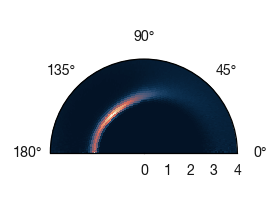

In [15]:
rbins = np.linspace(0,radial_line.max(), 200)
abins = np.linspace(0,np.pi, 200)

hist, _, _ = np.histogram2d(angular_line,radial_line, bins=(abins, rbins))

A, R = np.meshgrid(abins, rbins)

volume=2*np.pi*R**3/3*(1-(np.cos(A)))

volume=volume[:,1:]-volume[:,:-1]
volume=volume[1:,:]-volume[:-1,:]

from figure_formatting import figure_formatting as ff
from cmcrameri import cm

ff.set_formatting()
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))

pc = ax.pcolormesh((abins[:-1]+abins[1:])/2, (rbins[:-1]+rbins[1:])/2, hist.T/volume/100,cmap=cm.lipari,rasterized=True)
plt.xlim(0,np.pi)
plt.ylim(0,4)

fig.savefig('Spatial_distribution.pdf',dpi=1000)

